# Homework 2: Algorithmic Fairness, the Case Study of Recidivism Prediction

On May 23, 2016, ProPublica published an article with entitled "Machine Bias: There’s software used across the country to predict future criminals. And it’s biased against blacks.", https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing.  The details of the ProPublica methodology can be found at https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm.  The issue was further discussed in a Washington Post article, https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/?utm_term=.996662cc65f7.  There has been a great deal of discussion of the problem raised by ProPublica, and the last several years has seen a tremendous amount of research into algorithmic fairness in academia. A new academic community has emerged around this problem, and it gave birth to a new top Computer Science conference: https://fatconference.org.  The issues are taken very seriously by the community.

But what does fairness mean?  Many different definitions have been proposed, and not only is there no consensus on the correct notion of fairness, the different notions are in direct mathematical conflict.

In this homework, we will study the data used by ProPublica, and replicate parts of its analysis.  In addition, we will extend their analysis in several ways.  First, we'll obtain a more holistic picture of fairness in prediction by looking at several performance metrics, in addition to the one used by ProPublica (false positive rate).  Second, we will see how two standard machine learning algorithmis, which do not take race into account, perform under similar scrutiny.  Third, we will see concrete examples where different fairness criteria can be in direct conflict with one another.

There are two issues with ProPublica methodology that we need to first mention.  The first is that they consider people who have been arrested (pre-trial) in their study.  This is a problem, because the COMPAS scoring system was designed for individuals who would be on parole (see this paper for further details: http://www.crj.org/assets/2017/07/9_Machine_bias_rejoinder.pdf).  Second, they claim that they define recidivism as arrests within 2 years (730 days) after their initial arrest.  This is problematic as stated since arrests do not imply that a crime has been committed.  More fundamentally, they appear to use this as a part of their inclusion criteria in a way that is not transparent, and potentially buggy.  Specifically, ProPublic uses a dataset cox-parsed.csv for the analysis of bias that we focus on in this homework.  Starting from this dataset, they subselect individuals who (a) recidivate within 730 days (2 years), i.e., "(i.recidivist == True and i.lifetime <= 730)", *or* (b) recidivate after more than 730 days, i.e., "i.lifetime > 730". However, do not select those who do not recidivate and have a "lifetime" of <= 730. This latter population should not exist, given the ostensible definition of i.lifetime, but there are in fact 3000 individuals that satisfy this criterion.  This suggests a data coding error, an implementation bug, or both.  It could also be correct, but since the data and code are not fully documented, it is impossible to tell.

We will be consistent with ProPublica approach in using the same data.  However, we will use the entire dataset provided in cox-parsed.csv, rather than applying the ProPublica selection criteria.  Furthermore, solely to keep things simple, we will only use the "is-recid" field to determine whether an individual recidivated or not, ignoring the restriction of recidivism within 2 years.  Given all the potential issues with the data, as well as the simplification above, one should take the analysis in this homework with a grain of salt.  The goal is solely to appreciate the issues involved, both conceptually, and at a more technical level.

This homework involves implementation problems, as well as a written component.  In the written component, please provide the answers to the Questions below (highlighted in bold).

#### Submission Instructions: submit your solutions on Canvas.  Specifically:
#### 1) Programming: submit your implementation of lib.py
#### 2) Written portion: submit your answers to the questions below in hw3.pdf

## Part I: ProPublica Analysis

First, we will replicate a part of the ProPublica, with some small variations.

To begin, we will read all the data, and look at how many people we have total, as well as the number of recidivsts and non-recidivists among them (for our and ProPublica's definition of recidivism).

In [1]:
from lib import PeekyReader, Person, get_meta_scores, get_ground_truth, print_statistics_metascores, make_prediction_metascore, get_ave_costs, get_ave_costs_preds, plot_costs, train_test_split, learn, get_predictions, get_weights
from csv import DictReader

people = []
with open("./cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass
    
population = list(filter(lambda x: x.score_valid, people))
R = list(filter(lambda i: i.recidivist == True, population))
rset = set(R)
NR = [i for i in population if i not in rset]

print("Total Number of People:", len(population))
print("Number of recidivists:", len(R))
print("Number of non-recidivists:", len(NR))

Total Number of People: 10320
Number of recidivists: 3471
Number of non-recidivists: 6849


Now, the population list contains the full set of individuals in the dataset (each individual as a Person object).
R is the list of recidivists; rset is the corresponding set datastructure.
NR is the list of non-recidivists.

Next, we will replicate a simplified portion of the ProPublica study.

Let's start by grouping people by predicted meta-score, H(igh), M(edium), or L(ow).

In [2]:
High = list(filter(lambda i: i.high == True, population))
Medium = list(filter(lambda i: i.medium == True, population))
Low = list(filter(lambda i: i.low == True, population))

frac_High = len(High)/len(population)
frac_Medium = len(Medium)/len(population)
frac_Low = len(Low)/len(population)

print("Fraction predicted High:", frac_High)
print("Fraction predicted Medium:", frac_Medium)
print("Fraction predicted Low:", frac_Low)

Fraction predicted High: 0.18943798449612403
Fraction predicted Medium: 0.2531007751937985
Fraction predicted Low: 0.5574612403100775


As we can see, the majority of all individuals in the data are predicted to have a Low score -- that is, low recidivism risk.  The key point in the ProPublica analysis was evidence of bias against African-Americans in this population.  Specifically, they observe that African-Americans tend to have a higher fraction of Medium and High scores than Caucasians.

To see this, let's break up our High/Medium/Low instances into two subsets: those corresponding to African-Americans in the population, and those corresponding to Caucasians.  (Note: there are other racial and ethnic groups represented in the data as well. Just as ProPublica, we will ignore them for the purposes of the rest of this homework.  However, a comprehensive analysis would be expected to look at all such groups to identify *any* unfair advantages or disadvantages.)

In [3]:
afam = list(filter(lambda x : x.race == "African-American", population))
cauc = list(filter(lambda x : x.race == "Caucasian", population))

High_afam = list(filter(lambda i: i.high == True, afam))
Medium_afam = list(filter(lambda i: i.medium == True, afam))
Low_afam = list(filter(lambda i: i.low == True, afam))

frac_High_afam = len(High_afam)/len(afam)
frac_Medium_afam = len(Medium_afam)/len(afam)
frac_Low_afam = len(Low_afam)/len(afam)

print("African-American prediction statistics")
print("Fraction predicted High:", frac_High_afam)
print("Fraction predicted Medium:", frac_Medium_afam)
print("Fraction predicted Low:", frac_Low_afam)

High_cauc = list(filter(lambda i: i.high == True, cauc))
Medium_cauc = list(filter(lambda i: i.medium == True, cauc))
Low_cauc = list(filter(lambda i: i.low == True, cauc))

frac_High_cauc = len(High_cauc)/len(cauc)
frac_Medium_cauc = len(Medium_cauc)/len(cauc)
frac_Low_cauc = len(Low_cauc)/len(cauc)

print("Caucasian prediction statistics")
print("Fraction predicted High:", frac_High_cauc)
print("Fraction predicted Medium:", frac_Medium_cauc)
print("Fraction predicted Low:", frac_Low_cauc)

African-American prediction statistics
Fraction predicted High: 0.27611650485436895
Fraction predicted Medium: 0.2998058252427184
Fraction predicted Low: 0.4240776699029126
Caucasian prediction statistics
Fraction predicted High: 0.11142217245240761
Fraction predicted Medium: 0.22396416573348266
Fraction predicted Low: 0.6646136618141097


Let's look at the same data on a bar plot.

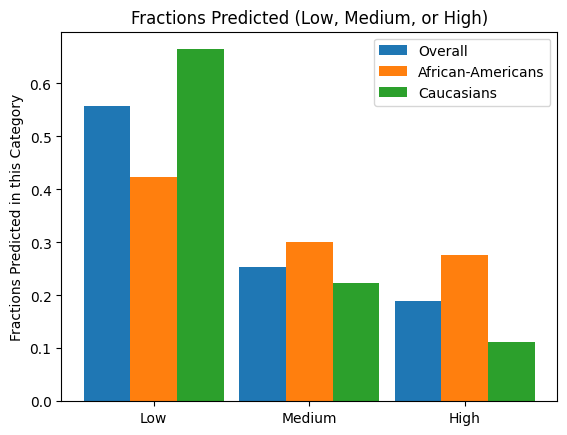

In [4]:
import matplotlib.pyplot as plt
import numpy as np
N = 3
fractions = (frac_Low, frac_Medium, frac_High)
fractions_afam = (frac_Low_afam, frac_Medium_afam, frac_High_afam)
fractions_cauc = (frac_Low_cauc, frac_Medium_cauc, frac_High_cauc)
ind = np.arange(N)
width = 0.3
p1 = plt.bar(ind, fractions, width)
p2 = plt.bar(ind+0.3, fractions_afam, width)
p3 = plt.bar(ind+0.6, fractions_cauc, width)
plt.ylabel('Fractions Predicted in this Category')
plt.title('Fractions Predicted (Low, Medium, or High)')
plt.xticks(ind+0.3, ('Low', 'Medium', 'High'))
plt.legend((p1[0], p2[0], p3[0]), ('Overall', 'African-Americans', 'Caucasians'))
plt.show()

As is evident from the plot above, a higher fraction of African-Americans are scored Medium or High (i.e., likely to recidivate) than Caucasians.  This is essentially what ProPublica found. But is this evidence of bias?  To understand what's going on, first, let's look at actual recidivism rates.

In [5]:
frac_recid = len(R)/len(population)
R_afam = list(filter(lambda i: i.recidivist == True, afam))
frac_recid_afam = len(R_afam)/len(afam)
R_cauc = list(filter(lambda i: i.recidivist == True, cauc))
frac_recid_cauc = len(R_cauc)/len(cauc)
print("Recidivism Rate: ",frac_recid)
print("Recidivism Rate (African-Americans): ",frac_recid_afam)
print("Recidivism Rate (Caucasians): ",frac_recid_cauc)

Recidivism Rate:  0.3363372093023256
Recidivism Rate (African-Americans):  0.3953398058252427
Recidivism Rate (Caucasians):  0.2869540873460246


Note that, as ProPublica observed in passing, African-Americans seem to recidivate at about a 10% higher rate that Caucasians.  This would account for some of the differences in predicted risk scores.  For example, a predictor that is perfectly accurate, and predicts all those who recidivate as High and those who don't as Low would place 10% more African-Americans into the High category than Caucasians.  **However, note that the difference in predicted High is actually closer to 15%**.  This indeed suggests some bias, but as we've seen in class, things can be quite subtle.

Let's dig somewhat deeper to see how COMPAS fares in terms of different measures of predictive effectiveness.  

## Problem 1 (50 points): Evaluating the Effectiveness and Fairness of COMPAS Recidivism Prediction

### Homework Question 1a [Coding] (20 points)

In order to evaluate how well the COMPAS approach predicts recidivism, and how fair these predictions are, we need a way to use its scoring system to make predictions.  Before we do this, we need to explain a bit about how COMPAS performs scoring.  There are actually three types of scores this algorithm returns.  The first is a raw score, which is a real number (positive or negative).  The second is a decile score, which is an integer between 1 and 10, where 1 is lowest risk, and 10 highest risk.  The third is what we call a "meta-score", which groups decile scores into three categories: Low (decile scores 1-4), Medium (scores 5-7), and High (scores 8-10).  Since much of the ProPublica analysis focuses on the meta-scores, we will as well.

Now, given the three score categories, Low, Medium, and High, we need to make a decision whether or not we predict the corresponding individual to recidivate.  There are two ways that we can do this:

1) Predict that anyone who is scored Medium or High (M/H) will recidivate, or

2) Predict that anyone who is scored as High (H) will recidivate, and others will not.

We now investigate how this particular decision (that is, what threshold to use to predict recidivism) impacts the different accuracy measures.

For this problem, your task will be to implement 4 functions in lib.py supplied as a part of your homework: 

1) Accuracy

2) False positive rate (FPR)

3) Positive predictive value (PPV, also known as precision)

4) False omission rate (FOR)

You will also implement three other helper functions: 

1) get_meta_scores(population): returns a list of meta-scores (Low/Medium/High) corresponding to the individuals in the population (supplied argument)

2) get_ground_truth(population): returns a list of Boolean values corresponding to the individuals in the population (supplied argument), where the value is True if the individual is a recidivist, and False otherwise (see the recidivist function in lib.py)

3) make_prediction_metascore(meta_scores, meta_threshold): predicts whether each meta-score in the supplied meta_scores list predicts True (recidivist) or False (non-recidivist) given the meta_threshold.  For example, if a meta-score is Low, prediction is always False (non-recidivist).  However, if the meta-score is Medium, it is True if the threshold is Medium (that is, we predict True for scores Medium and above), and False if the threshold is High.

Note that in the ProPublica analysis, the Medium threshold was used.  This means that more people are potentially erroneously predicted to be recidivists than if we were to use a more conservative "High" threshold.  This will be borne out by the analysis below, once you correctly implement the required functions in lib.py.

**NOTE: once a function has been implemented, you will need to restart the current workspace.  To do this, go to Kernel, and select Restart & Run All.**

Let's see what we get on the different metrics, in terms of overall prediction effectiveness of COMPAS.

In [6]:
meta_scores = get_meta_scores(population)
ground_truth = get_ground_truth(population)
print_statistics_metascores(meta_scores, ground_truth)

Predict M/H as Positives (ProPublica)
Accuracy:  0.6358527131782946 FPR:  0.35435830048182215 PPV:  0.468578935844099 FOR:  0.23135755258126195
Predict only H as Positives
Accuracy:  0.6759689922480621 FPR:  0.1334501387063805 PPV:  0.5324808184143223 FOR:  0.2904961147638972


### Homework Question 1b (10 points): How well does COMPAS work?  Which threshold (Medium or High) seems to work better?  Why?  Which metrics favor which threshold?

The common way to evaluate algorithmic fairness is by looking at the error metrics in comparison for the different groups of people.  In this case, we will compare these metrics (statistics) for African-American and Caucasian individuals.  Whenever one group performs significantly better on a particular metric (say, accuracy), we would say that the approach is unfair to the other group on that metric.

In [7]:
meta_scores_afam = get_meta_scores(afam)
ground_truth_afam = get_ground_truth(afam)
print("Statistics for African-American Population")
print_statistics_metascores(meta_scores_afam, ground_truth_afam)

Statistics for African-American Population
Predict M/H as Positives (ProPublica)
Accuracy:  0.5899029126213592 FPR:  0.4884393063583815 PPV:  0.48718813216453133 FOR:  0.2706043956043956
Predict only H as Positives
Accuracy:  0.6279611650485437 FPR:  0.20905587668593448 PPV:  0.5421940928270043 FOR:  0.33932403433476394


In [8]:
meta_scores_cauc = get_meta_scores(cauc)
ground_truth_cauc = get_ground_truth(cauc)
print("Statistics for Caucasian Population")
print_statistics_metascores(meta_scores_cauc, ground_truth_cauc)

Statistics for Caucasian Population
Predict M/H as Positives (ProPublica)
Accuracy:  0.6704927211646137 FPR:  0.26501766784452296 PPV:  0.4365609348914858 FOR:  0.21145745577085087
Predict only H as Positives
Accuracy:  0.7141657334826428 FPR:  0.077345897133883 PPV:  0.5050251256281407 FOR:  0.25960932577189666


### Homework Question 1c (10 points): For each metric, answer two questions: 1) Do you observe a bias? 2) Who is disadvantaged?

### Homework Question 1d (10 points): How does the choice of a threshold (Medium vs. High) impact the fairness of the algorithm?

## Part II: Measuring Fairness in terms of Harms

Next, let's look at another way of measuring equity: costs corresponding to the harms incurred by the two groups.  Remember that in binary classification (which is one way to view this problem), there are two kinds of mistakes: false positives and false negatives.  Suppose that we only say that an individual will recidivate if their score is High.  In our case then, a false positive is someone scored High who ultimately does not commit another crime, and a false negative is someone who is scored Medium or Low but does recidivate.

One way we can measure a cost incurred by a group, such as African-Americans, is to count up the costs of all false positives and the costs of all false negatives of individuals in the group, and then take the average cost per individual.  It seems quite natural to expect that we treat different groups fairly in terms of such costs.  But where do costs come from?  In other words, how do we know what a false positive or a false negative costs?

We won't answer this question here.  Instead, we will study what happens as the relative costs of false positives and false negatives change.  We can keep the cost of each false negative to be 1, and vary the cost of each false positive, which we term c.  A useful way to think about this is that false positives are costs (harms) to the individuals (and their families), whereas false negatives are (potential) harms to their communities (for example, crime victims).

### Problem 2 (30 points): Computing and Measuring Prediction Costs and Cost Inequity

### Homework Question 2a [Coding] (20 points):

Your first programming task is to implement three helper functions:

1) compute_cost(predictions, ground_truth, costfp): this computes the total cost of predictions with respect to a list of predictions and corresponding ground_truth values for some population.  The cost of each false negative is assumed to be 1, and the cost of each false positive is costfp (specified as the last argument)

2) get_ave_costs_preds(predictions, ground_truth, costs): this computes average costs per person given a list of predictions and a list of ground_truth, for each cost value specified in the list costs.

3) get_ave_costs(meta_scores, ground_truth, costs): this computes average costs per person given a list of meta_scores (meta-scores for individuals) and a list of ground_truth, for each cost value specified in the list costs.

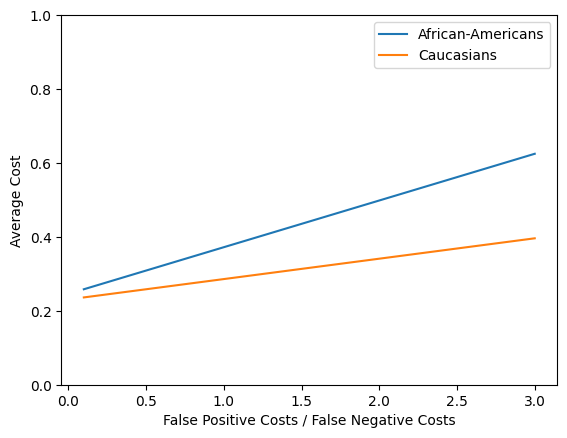

In [9]:
import numpy as np
costs = np.arange(0.1,3.1,0.1)
total_costs_afam = get_ave_costs(meta_scores_afam, ground_truth_afam, costs)
total_costs_cauc = get_ave_costs(meta_scores_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_afam, total_costs_cauc)

### Homework Question 2b (10 points): What do we see?  Is there an equity of harms, or is one group more harmed, on average, than the other?  What happens as we increase the relative importance of false positives?

## Part III: Machine Learning and Fairness

COMPAS scoring system is not transparent, and it's not clear whether what we have seen so far are a product of something that's inherent in the scoring approach, or is a more general phenomenon.

We will study this by applying two standard machine learning algorithms to the problem of predicting recidivism.

We will learn to predict recidivism (binary classification).  We will use the following attributes as features:

1) age

2) number of priors (priors method in lib.py)

3) whether the current arrest was for a felony (is_felony in lib.py)

4) juvenile felony count (juvenile_felony_count)

5) juvenile misdemeanor count (juvenile_misdemeanor_count) 

6) count of other juvenile crimes (juvenile_other_count)

**As you run each box below, be sure to wait before the In [*] changes to In [number].  The former means that it's still executing, and some of these will take a little while to run.**

## Problem 3 (30 points): Implement the Learning Routines

### Homework Question 3a [Coding] (20 points)

In this part, you will implement three functions that allow us to run learning algorithms and make predictions on training/test recidivism data.  The three functions you'll implement are (20 points):

1) construct_feature_matrix(population): this constructs a matrix with rows corresponding to the individuals in the population (argument), and 6 columns (indexed 0 through 5) corresponding to the 6 features (attributes) used for classification described above.  The function returns the resulting matrix, which is a numpy 2d array with 6 columns.

2) learn(population, model, weights): this function does the learning.  It takes 3 arguments: population (the dataset to learn from), model (learning model), and weights (each sample may have different importance; we'll see application of this below).  Much of this function is already implemented for you.

3) get_predictions(population, model): returns an array (list) of predictions corresponding to the specified dataset (population), given a learned model.

First, we will import the relevant machine learning libraries.

In [10]:
from sklearn import tree
from sklearn import svm

The next step is crucial in machine learning: we split up the dataset into two parts, 1) training data, and 2) test data.  All learning will be performed on training data.  Our analysis of the learned model will then use test data.

Equally important is the fact that we use **all** of the training data to train the models.  In particular, the models do not make use of race, ethnicity, or gender.

In [11]:
train_test_split(population, 0.5)

train = list(filter(lambda x: x.is_training == True, population))
test = list(filter(lambda x: x.is_training == False, population))

test_afam = list(filter(lambda x: x.is_training == False, afam))
test_cauc = list(filter(lambda x: x.is_training == False, cauc))

First, we find the ground truth for the test data.

In [12]:
ground_truth_afam = get_ground_truth(test_afam)
ground_truth_cauc = get_ground_truth(test_cauc)

Next, we train the Decision Tree classifier on train data, and then obtain its predictions on test data for African-Americans and Caucasians.

In [13]:
model = tree.DecisionTreeClassifier()
model = learn(train, model)
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)

Now, we are ready to take a look at the resulting average costs (harms) for African-Americans and Caucasians.

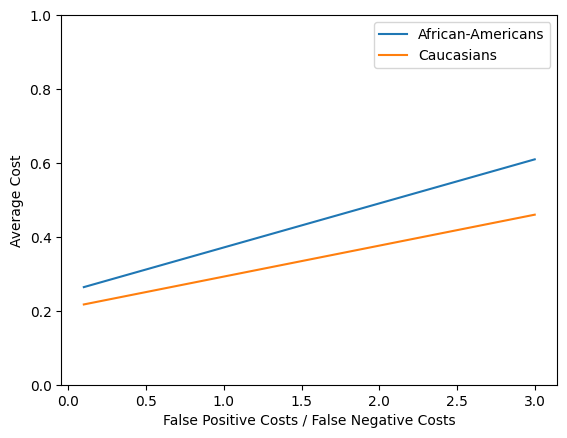

In [14]:
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

To ensure that the results aren't an artifact of the particular learning algorith, let's try another one, linear Support Vector Machine classifier (SVM)

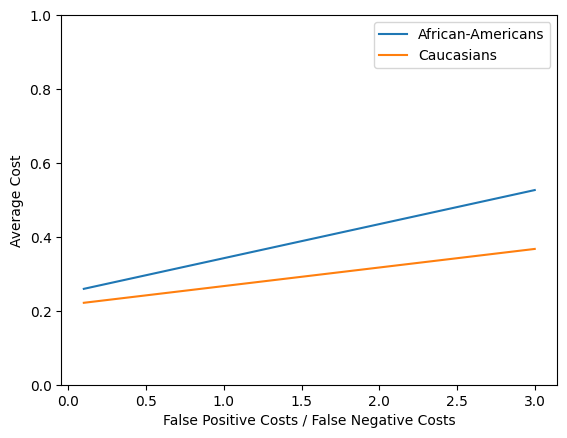

In [15]:
model = svm.SVC(gamma="auto")
model = learn(train, model)
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

### Homework Question 3b (10 points): What have you observed? How do the two classifiers (decision tree, SVM) compare? 

## Part IV: Cost-Sensitive Learning

What if we explicitly take misclassification costs into account in learning? That is, we can use **cost-sensitive learning**.  

First, let's try having false positives be more costly than false negatives.  We'll do this for Decision Tree first.

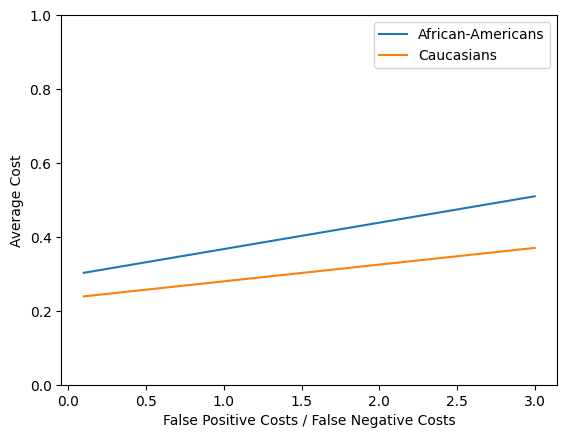

In [16]:
model = tree.DecisionTreeClassifier(class_weight = {0:.8, 1:.2})
model = learn(train, model)
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

And now for SVM:

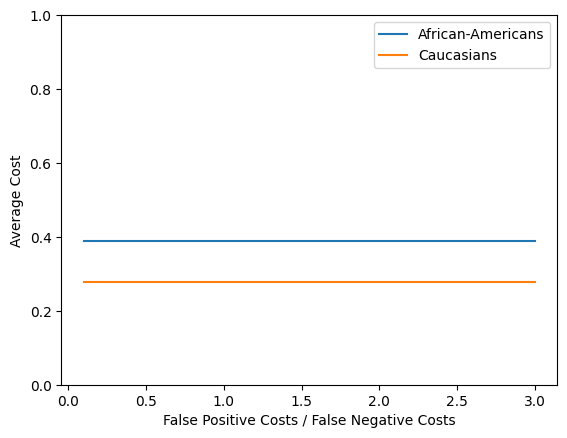

In [17]:
model = svm.SVC(gamma="auto", class_weight = {0:.8, 1:.2})
model = learn(train, model)
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

How about the reverse: making false negatives be more costly than false positives?  Again, starting with the Decision Tree.

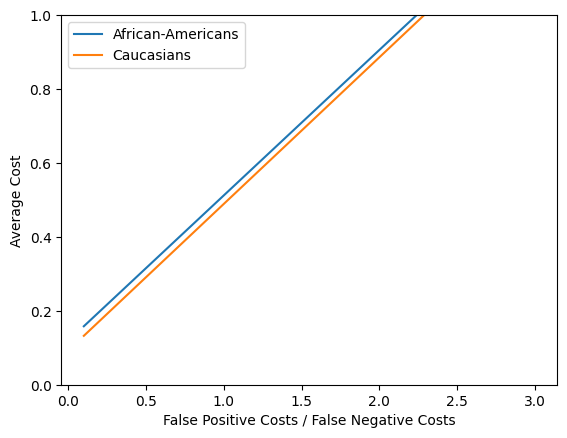

In [18]:
model = tree.DecisionTreeClassifier(class_weight = {0:.2, 1:.8})
model = learn(train, model)
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

Again, for SVM

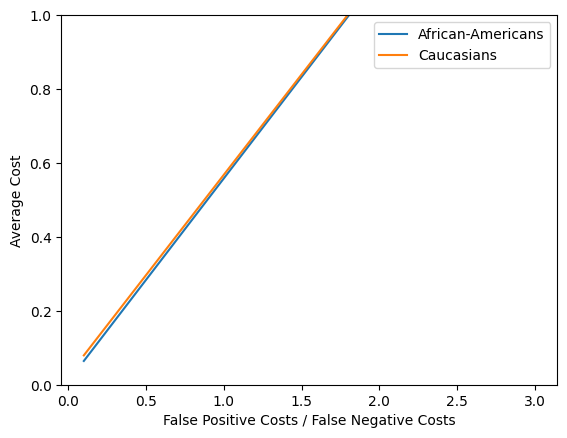

In [19]:
model = svm.SVC(gamma="auto", class_weight = {0:.2, 1:.8})
model = learn(train, model)
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

### Homework Question 4a (10 points): What is the impact of false positive rate being more and less costly in the case of Decision Tree classifier?  What about SVM?

Let's explore one more option: we can change the relative costs of errors made on different populations.  Specifically, we will see what happens if we penalize the classifier more for errors made on African-Americans than on all others. In particular, we'll see what happens when the penalty ratio is (a) 2, and (b) 100, if we use SVM.

### Homework Question 4b [Coding] (10 points): Implement a Function to Calculate Sample Weights

You will implement a helper function to accomplish the goal of learning when different individuals have different importance to the classifier.  In our case, we will explore what happens if we use a higher penalty for making mistakes on African-Americans than on Caucasian individuals.  Specifically, you will implement the following function:

get_weights(population, w): given a specified population, return weights for each individual, which are set to w if the individual is African-American, and to 1 otherwise.

We'll start by setting weights for African-Americans in the data to be 2x those for everyone else.

In [20]:
weights = get_weights(train, 2)

Now, let's try learning the SVM model again, but with the modified costs (sample weights).

In [21]:
model = svm.SVC(gamma="auto")
model = learn(train, model, weights)

Let's see how this affects our prediction costs for African-Americans and Caucasians.

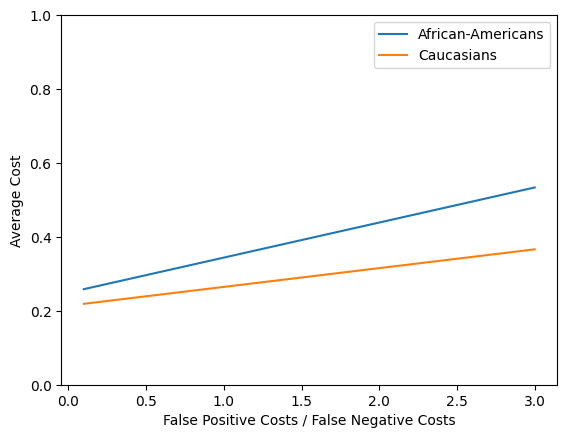

In [22]:
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

Now, we'll try a more dramatic re-weighing: mistakes on African-American individuals will be treated as 100 times more important than on everyone else.

In [23]:
weights = get_weights(train, 100)
model = svm.SVC(gamma="auto")
model = learn(train, model, weights)

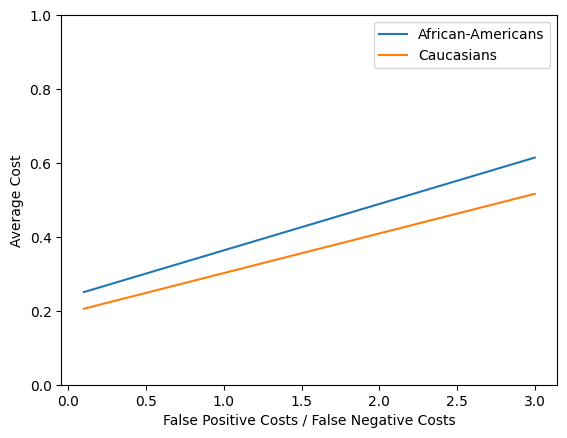

In [24]:
predictions_afam = get_predictions(test_afam, model)
predictions_cauc = get_predictions(test_cauc, model)
total_costs_preds_afam = get_ave_costs_preds(predictions_afam, ground_truth_afam, costs)
total_costs_preds_cauc = get_ave_costs_preds(predictions_cauc, ground_truth_cauc, costs)
plot_costs(costs, total_costs_preds_afam, total_costs_preds_cauc)

### Homework Question 4c (10 points): What do you observe?

### Homework Question 5 (10 points): What have you learned from this homework?  Do you feel that the ProPublica analysis was fair to COMPAS?  Explain.  Could COMPAS have done a better, fairer job, predicting recidivism?  What should be done in practice?